# Susie finemapping analysis

In [1]:
setwd("~/project-gandalm/isoform_twas/eqtl_new/results/susie_finemap")
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(tidyr))
suppressMessages(library(wesanderson))
suppressMessages(library(VennDiagram))

## Results summary-ALL
- We started with 10094 eGenes identified by FastQTL permutation pass for ALL ancestries with 90 HCP in covariates
- After filtering for CS purity: 
    - 7654 genes have non-low purity CS
    - 10671 unique CS
    - 122,050 unique variants in CS
- Of the 10671 CS:
    - 2423 contain exactly one SNP (strong candidates for causal variants)
    - 1291 contain exactly two SNPs
    - median size 5, mean 15.17, max1897
- Of the 7654 genes:
    - 5515 have exactly one CS
    - up to 8

### 1. all variants that belong to a non-low purity credible set

In [2]:
var_in_cs <- fread("mixed_ciseqtl_90hcp_perm.txt.gz", data.table = F)
dim(var_in_cs)

[1] 161929     17

#### How many eGenes got finemapped non-low purity credible sets?

In [4]:
length(unique(var_in_cs$phenotype_id))

[1] 7654

#### How many unique variants in all CS? 

In [5]:
length(unique(var_in_cs$variant_id))

[1] 122050

#### How many unique non-low purity CS?

In [6]:
length(unique(var_in_cs$cs_id))

[1] 10671

#### Sorted by chr and pos of genes

In [2]:
sorted_df_all <- fread("mixed/mixed_ciseqtl_90hcp_perm_purity_filtered.txt.gz", data.table = F)
dim(sorted_df_all)

[1] 161929     17

#### How many CS contain exactly one SNP?
**Note chr17 many genes with large CS.**

In [4]:
dim(sorted_df_all[!duplicated(sorted_df_all$cs_id),])

[1] 10671    17

In [3]:
cs_id_size_all <- sorted_df_all[!duplicated(sorted_df_all$cs_id),] %>% select(cs_id, cs_size, finemapped_region, phenotype_id)

In [29]:
cs_id_size_all %>% filter(cs_size > 500)

cs_id,cs_size,finemapped_region
<chr>,<int>,<chr>
ENSG00000175395_L2,547,chr10:37265574-39265574
ENSG00000227540_L1,591,chr10:74012548-76012548
ENSG00000266918_L3,1897,chr17:42608942-44608942
ENSG00000264589_L1,1464,chr17:42973045-44973045
ENSG00000073969_L2,1469,chr17:43668034-45668034
ENSG00000185829_L4,1066,chr17:43657047-45657047
ENSG00000260075_L2,936,chr17:43450220-45450220
ENSG00000261575_L1,1067,chr17:43344402-45344402
ENSG00000263715_L1,1719,chr17:42697709-44697709


In [6]:
sum(cs_id_size_all$cs_size==1)
sum(cs_id_size_all$cs_size==2)

[1] 2423

[1] 1291

In [27]:
summary(cs_id_size_all$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    5.00   15.17   14.00 1897.00 

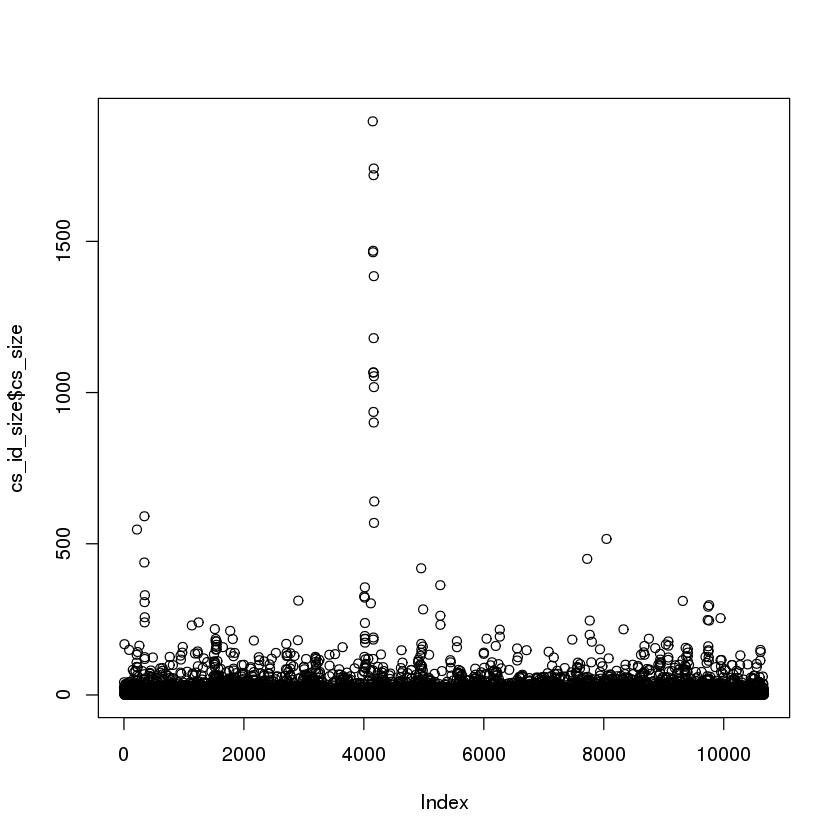

In [14]:
plot(cs_id_size_all$cs_size)

#### How many genes have exactly one CS?

In [3]:
genes_with_cs <- unique(sorted_df_all$phenotype_id)
df <- data.frame("gene" = genes_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df_all[sorted_df_all$phenotype_id == df[i,1],]$cs_id))
}

In [44]:
summary(df$cs_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.394   2.000   8.000 

In [45]:
dim(df)

[1] 7654    2

In [46]:
sum(df$cs_count == 1)

[1] 5515

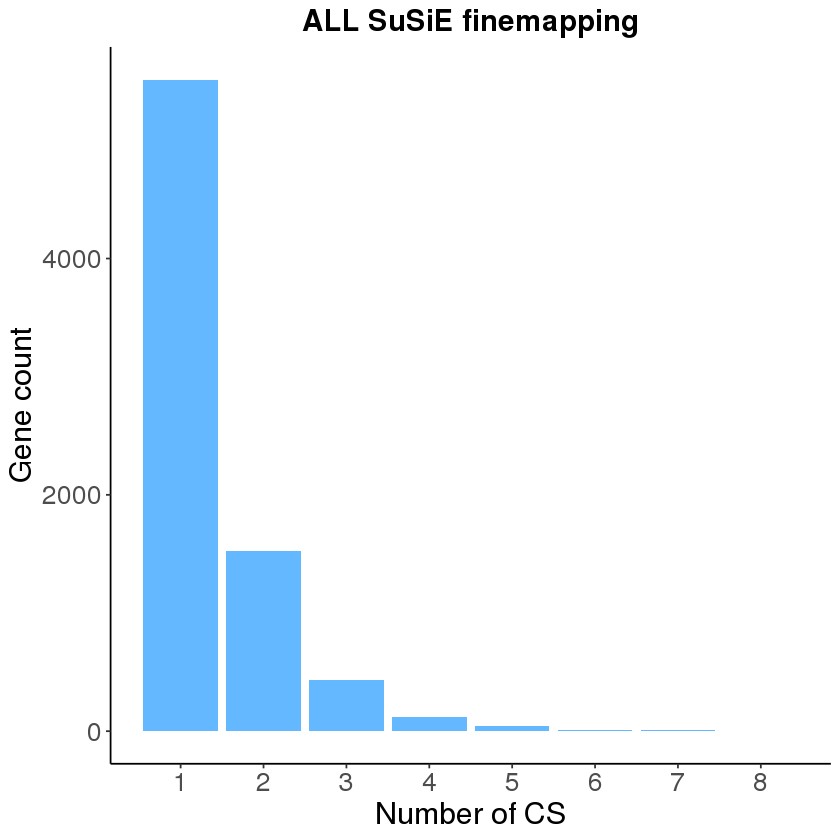

In [33]:
p <- ggplot(df, aes(x = cs_count)) +
  geom_bar(fill = "steelblue1") +
  scale_x_continuous(breaks = seq(1, 9, by = 1)) +
  labs(x = "Number of CS", y = "Gene count") +
  ggtitle("ALL SuSiE finemapping") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5))
p

In [34]:
ggsave("../../figures/susie_num_cs.png", p, width = 6, height = 6)

#### Number of independent signals compared to conditional QTL mapping

In [7]:
conditional <- fread("../mixed_conditional_90hcp/conditional_top_variants.txt", data.table = F)

In [8]:
# filter for variant with backward p-value below threshold of this gene
conditional <- conditional %>% filter(V20 == 1)
# how many ranks of independent QTL each gene has?
df_conditional <- data.frame("gene" <- unique(conditional$V1),
                 "num_rank" <- NA)
for (i in 1:nrow(df_conditional)) {
  gene <- df_conditional[i,1]
  df_conditional[i,2] <- max(conditional[conditional$V1==gene,12]) + 1
}
names(df_conditional) <-c("gene","num_rank")

In [9]:
table(df_conditional$num_rank)


   1    2    3    4    5    6    7    8   10 
7312 2413  815  292   95   35   10    7    1 

In [9]:
# overlapping genes
df <- df %>% left_join(df_conditional, by = "gene")
head(df)

,gene,cs_count,num_rank
,<fct>,<int>,<dbl>
1,ENSG00000166024,1,1
2,ENSG00000119943,1,1
3,ENSG00000205740,1,1
4,ENSG00000119946,1,1
5,ENSG00000014919,1,1
6,ENSG00000233690,1,1


In [11]:
dim(df)

[1] 7654    3

In [11]:
sum(complete.cases(df))

[1] 7491

In [10]:
df <- df[complete.cases(df),]

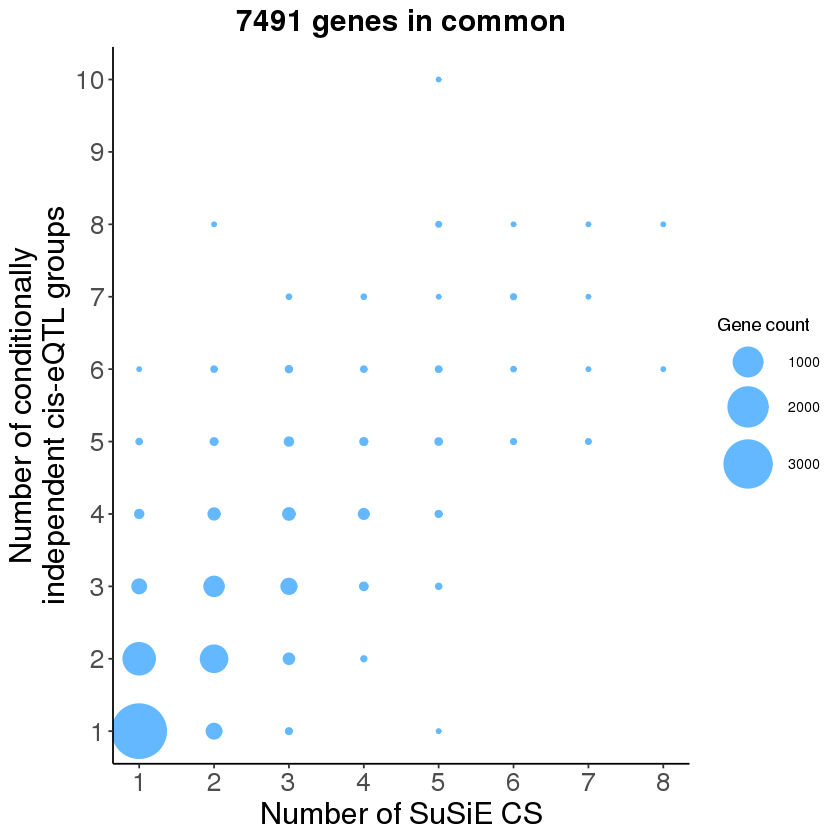

In [21]:
p <- ggplot(df, aes(x = cs_count, y = num_rank)) +
  geom_count(color = "steelblue1") +
#   geom_count(aes(color = ..n..), size=5) +
  scale_size(range = c(1, 15), "Gene count") + 
#   geom_hex() +
  labs(x = "Number of SuSiE CS", y = "Number of conditionally\nindependent cis-eQTL groups") +
  ggtitle("7491 genes in common") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5)) +
  scale_x_continuous(breaks = seq(1,8,by=1)) +
  scale_y_continuous(breaks = seq(1,10,by=1)) 
p

In [22]:
ggsave("../../figures/susie_conditional.png", p, width=6, height=6)

In [20]:
cor(df$cs_count, df$num_rank, method = 'spearman')
cor(df$cs_count, df$num_rank, method = 'pearson')

[1] 0.6607808

[1] 0.7241307

#### sum of PIP in CS

In [30]:
cs_sum_pip <- sorted_df_all %>% group_by(cs_id) %>% summarise(sum_pip = sum(pip))
summary(cs_sum_pip)

`summarise()` ungrouping output (override with `.groups` argument)



    cs_id              sum_pip      
 Length:10671       Min.   :0.9500  
 Class :character   1st Qu.:0.9651  
 Mode  :character   Median :0.9791  
                    Mean   :0.9820  
                    3rd Qu.:0.9984  
                    Max.   :1.5440  

### 2. all credible sets (not filtered for purity)

In [14]:
cs <- fread("mixed_ciseqtl_90hcp_perm.cred.txt.gz", data.table = F)
dim(cs)

[1] 15153     9

In [15]:
head(cs)

,phenotype_id,cs_id,cs_index,finemapped_region,cs_log10bf,cs_avg_r2,cs_min_r2,cs_size,low_purity
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
1,ENSG00000273079,ENSG00000273079_L1,L1,chr12:13134890-15134890,2.141959084,1.000000000,1.000000e+00,1,FALSE
2,ENSG00000256751,ENSG00000256751_L1,L1,chr12:13720326-15720326,17.034654510,0.960079401,9.209719e-01,2,FALSE
3,ENSG00000182993,ENSG00000182993_L1,L1,chr12:13956599-15956599,32.321039529,1.000000000,1.000000e+00,1,FALSE
4,ENSG00000182993,ENSG00000182993_L3,L3,chr12:13956599-15956599,0.003084303,0.004807284,2.735455e-09,5552,TRUE
5,ENSG00000286107,ENSG00000286107_L1,L1,chr12:13958041-15958041,6.369879867,0.773075121,5.753129e-01,2,FALSE
6,ENSG00000256650,ENSG00000256650_L1,L1,chr12:14267631-16267631,1.507194318,0.819963722,5.982717e-01,4,FALSE


In [16]:
length(unique(cs$phenotype_id))

[1] 10093

In [17]:
table(cs$low_purity)


FALSE  TRUE 
10671  4482 

In [35]:
head(cs %>% filter(low_purity))

,phenotype_id,cs_id,cs_index,finemapped_region,cs_log10bf,cs_avg_r2,cs_min_r2,cs_size,low_purity
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
1,ENSG00000111261,ENSG00000111261_L1,L1,chr12:11503175-13503175,4.07944167,0.726510897,1.744063e-01,11,TRUE
2,ENSG00000255670,ENSG00000255670_L2,L2,chr12:11638286-13638286,0.45976964,0.003582169,4.231532e-10,2859,TRUE
3,ENSG00000111269,ENSG00000111269_L1,L1,chr12:11764760-13764760,2.16559198,0.568307145,9.618169e-02,25,TRUE
4,ENSG00000275963,ENSG00000275963_L5,L5,chr12:11801872-13801872,0.05347751,0.003353675,1.313858e-09,5537,TRUE
5,ENSG00000183150,ENSG00000183150_L7,L7,chr12:11849140-13849140,0.01117094,0.003360231,1.960944e-10,5668,TRUE
6,ENSG00000178878,ENSG00000178878_L2,L2,chr12:11878850-13878850,1.01661800,0.034086444,1.156653e-06,30,TRUE


**See code for low purity definition:**
```{r}
dplyr::mutate(
        cs_avg_r2 = mean.abs.corr^2,
        cs_min_r2 = min.abs.corr^2,
        low_purity = min.abs.corr < 0.5
      )
```

In [36]:
max(cs %>% filter(low_purity) %>% select(cs_min_r2))

[1] 0.2498847

In [37]:
min(cs %>% filter(!low_purity) %>% select(cs_min_r2))

[1] 0.2500968

### 3. all tested variants (very big file)

## EUR results
- We started with 5296 eGenes identified by FastQTL permutation pass for EUR with 50 HCP in covariates
- After filtering for CS purity: 
    - 4619 genes have non-low purity CS
    - 5559 unique CS
    - 95842 unique variants in CS
- Of the 5559 CS:
    - 1018 contain exactly one SNP (strong candidates for causal variants)
    - 560 contain exactly two SNPs
    - median size 7, mean 23.08, max 1945
- Of the 4619 genes:
    - 3835 have exactly one CS
    - up to 5

In [4]:
sorted_df_eur <- fread("eur/eur_ciseqtl_50hcp_perm_purity_filtered.txt.gz", data.table = F)
dim(sorted_df_eur)

[1] 128302     17

In [38]:
# how many unique variants in all CS
length(unique(sorted_df_eur$variant_id))

[1] 95842

In [48]:
# how many unique non-low purity CS
length(unique(sorted_df_eur$cs_id))

[1] 5559

In [5]:
# how many CS contain exactly one/two SNP
cs_id_size_eur <- sorted_df_eur[!duplicated(sorted_df_eur$cs_id),] %>% select(phenotype_id, cs_id, cs_size, finemapped_region)
sum(cs_id_size_eur$cs_size==1)
sum(cs_id_size_eur$cs_size==2)
dim(cs_id_size_eur)

[1] 1018

[1] 560

[1] 5559    4

In [9]:
summary(cs_id_size_eur$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    7.00   23.08   22.00 1945.00 

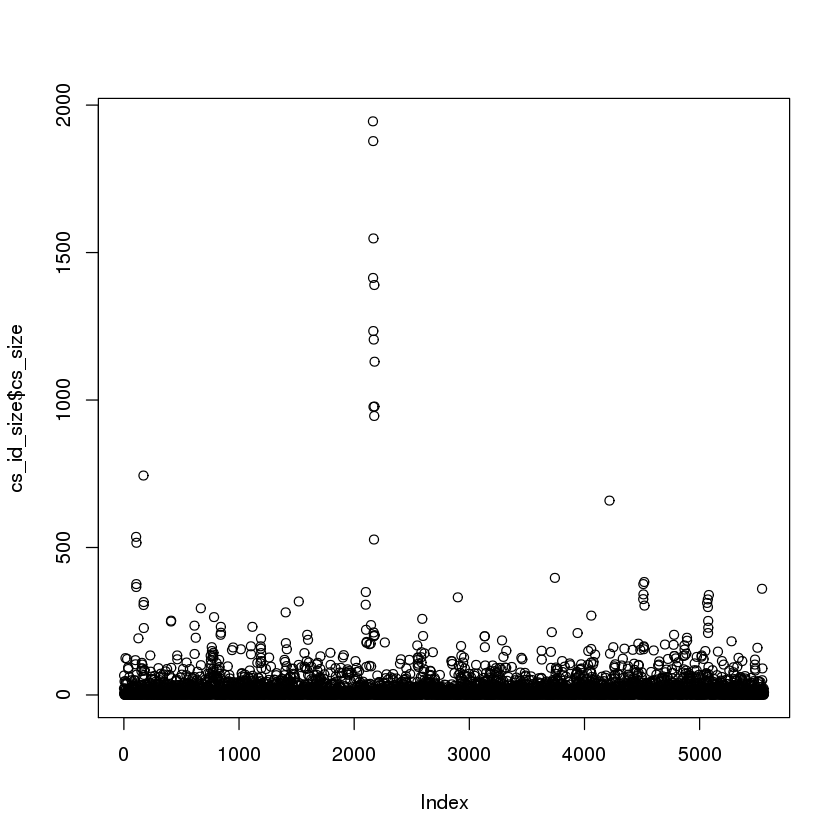

In [23]:
plot(cs_id_size_eur$cs_size)

In [49]:
# how many genes have exactly one CS
genes_with_cs <- unique(sorted_df_eur$phenotype_id)
df <- data.frame("gene" = genes_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df_eur[sorted_df_eur$phenotype_id == df[i,1],]$cs_id))
}
summary(df$cs_count)
sum(df$cs_count == 1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.204   1.000   5.000 

[1] 3835

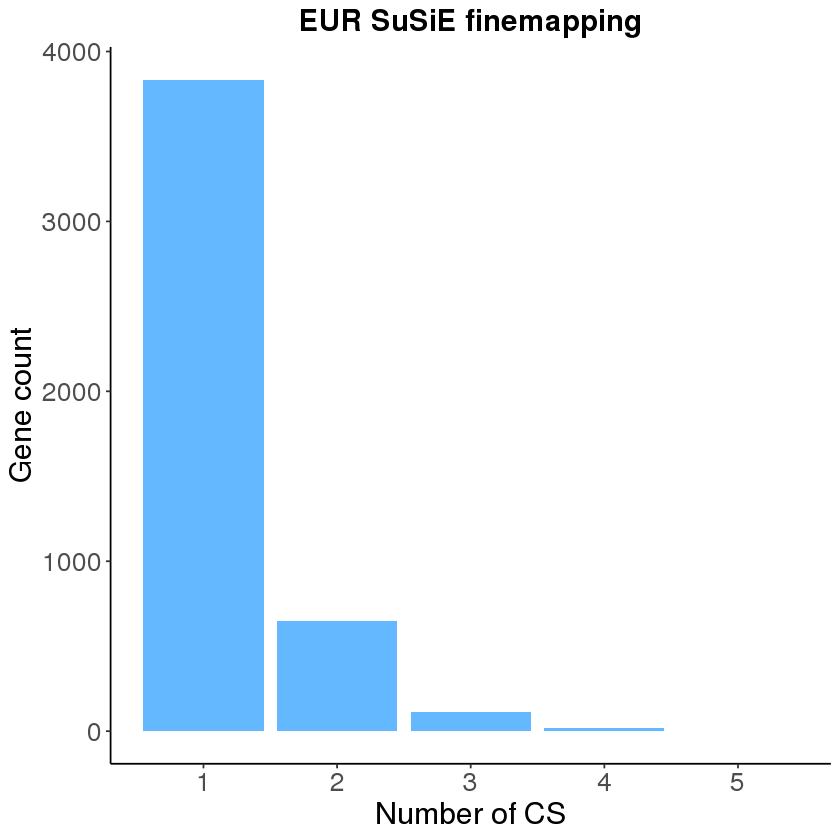

In [40]:
p <- ggplot(df, aes(x = cs_count)) +
  geom_bar(fill = "steelblue1") +
  scale_x_continuous(breaks = seq(1, 9, by = 1)) +
  labs(x = "Number of CS", y = "Gene count") +
  ggtitle("EUR SuSiE finemapping") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5))
p

In [41]:
ggsave("../../figures/susie_num_cs_eur.png", p, width = 6, height = 6)

## AMR results
- We started with 3242 eGenes identified by FastQTL permutation pass for AMR with 15 HCP in covariates
- After filtering for CS purity: 
    - 2676 genes have non-low purity CS
    - 3009 unique CS
    - 55636 unique variants in CS
- Of the 3009 CS:
    - 520 contain exactly one SNP (strong candidates for causal variants)
    - 279 contain exactly two SNPs
    - median size 8, mean 31.53, max 2243
- Of the 2676 genes:
    - 2391 have exactly one CS
    - up to 4

In [6]:
sorted_df_amr <- fread("amr/amr_ciseqtl_15hcp_perm_purity_filtered.txt.gz", data.table = F)
dim(sorted_df_amr)

[1] 94868    17

In [3]:
# how many eGenes got finemapped non-low purity CS
length(unique(sorted_df_amr$phenotype_id))

[1] 2676

In [4]:
# how many unique variants in all CS
length(unique(sorted_df_amr$variant_id))

[1] 55636

In [5]:
# how many unique non-low purity CS
length(unique(sorted_df_amr$cs_id))

[1] 3009

In [7]:
# how many CS contain exactly one/two SNP
cs_id_size_amr <- sorted_df_amr[!duplicated(sorted_df_amr$cs_id),] %>% select(phenotype_id, cs_id, cs_size, finemapped_region)
sum(cs_id_size_amr$cs_size==1)
sum(cs_id_size_amr$cs_size==2)
dim(cs_id_size_amr)

[1] 520

[1] 279

[1] 3009    4

In [32]:
summary(cs_id_size_amr$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    8.00   31.53   22.00 2243.00 

In [9]:
# how many genes have exactly one CS
genes_with_cs <- unique(sorted_df_amr$phenotype_id)
df <- data.frame("gene" = genes_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df_amr[sorted_df_amr$phenotype_id == df[i,1],]$cs_id))
}
summary(df$cs_count)
sum(df$cs_count == 1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.124   1.000   4.000 

[1] 2391

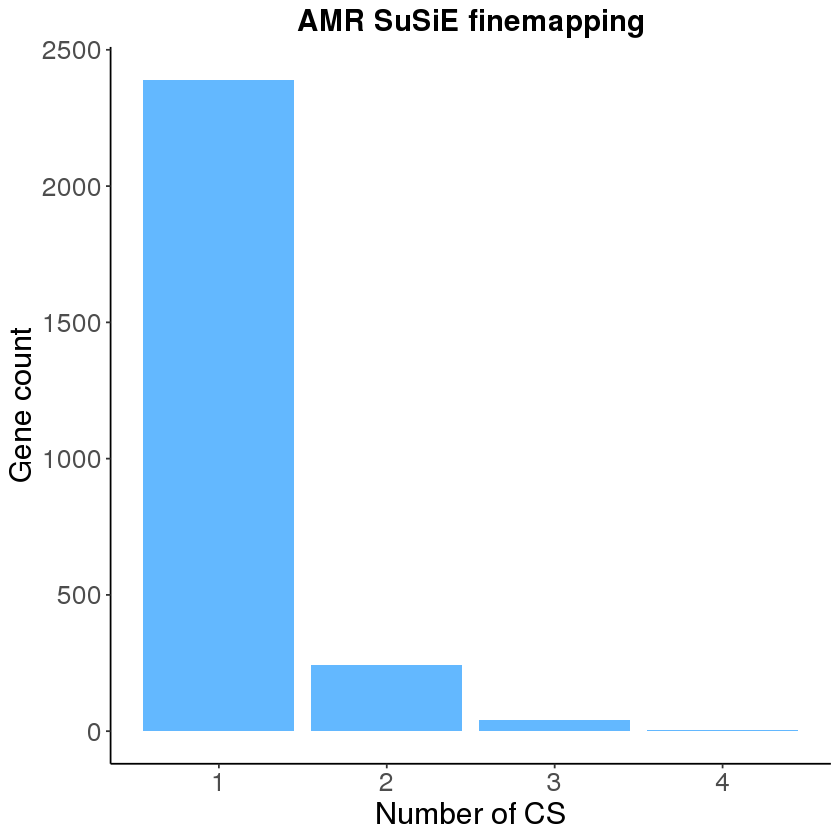

In [10]:
p <- ggplot(df, aes(x = cs_count)) +
  geom_bar(fill = "steelblue1") +
  scale_x_continuous(breaks = seq(1, 9, by = 1)) +
  labs(x = "Number of CS", y = "Gene count") +
  ggtitle("AMR SuSiE finemapping") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5))
p

In [11]:
ggsave("../../figures/susie_num_cs_amr.png", p, width = 6, height = 6)

## AFR results
- We started with 1876 eGenes identified by FastQTL permutation pass for AFR with 25 HCP in covariates
- After filtering for CS purity: 
    - 1823 genes have non-low purity CS
    - 2288 unique CS
    - 27369 unique variants in CS
- Of the 2288 CS:
    - 617 contain exactly one SNP (strong candidates for causal variants)
    - 297 contain exactly two SNPs
    - median size 4, mean 15.85, max 1672
- Of the 1823 genes:
    - 1433 have exactly one CS
    - up to 4

In [8]:
sorted_df_afr <- fread("afr/afr_ciseqtl_25hcp_perm_purity_filtered.txt.gz", data.table = F)
dim(sorted_df_afr)

[1] 36256    17

In [13]:
# how many eGenes got finemapped non-low purity CS
length(unique(sorted_df_afr$phenotype_id))

[1] 1823

In [14]:
# how many unique variants in all CS
length(unique(sorted_df_afr$variant_id))

[1] 27369

In [15]:
# how many unique non-low purity CS
length(unique(sorted_df_afr$cs_id))

[1] 2288

In [9]:
# how many CS contain exactly one/two SNP
cs_id_size_afr <- sorted_df_afr[!duplicated(sorted_df_afr$cs_id),] %>% select(phenotype_id, cs_id, cs_size, finemapped_region)
sum(cs_id_size_afr$cs_size==1)
sum(cs_id_size_afr$cs_size==2)
dim(cs_id_size_afr)

[1] 617

[1] 297

[1] 2288    4

In [17]:
summary(cs_id_size_afr$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    4.00   15.85   11.25 1672.00 

In [18]:
# how many genes have exactly one CS
genes_with_cs <- unique(sorted_df_afr$phenotype_id)
df <- data.frame("gene" = genes_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df_afr[sorted_df_afr$phenotype_id == df[i,1],]$cs_id))
}
summary(df$cs_count)
sum(df$cs_count == 1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.255   1.000   4.000 

[1] 1433

In [22]:
dim(df)

[1] 1823    2

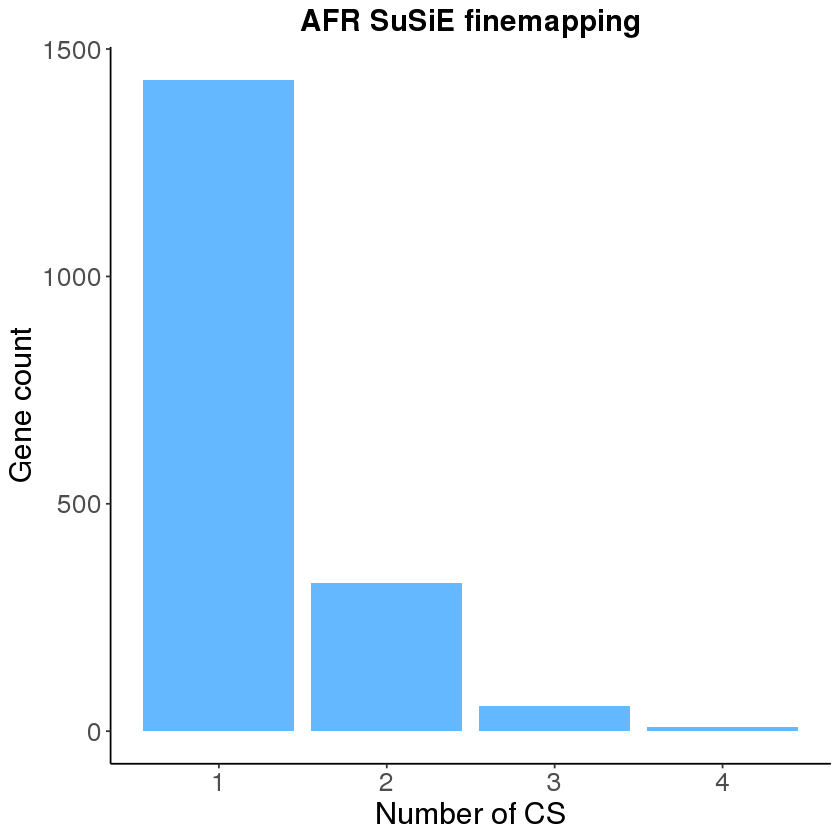

In [19]:
p <- ggplot(df, aes(x = cs_count)) +
  geom_bar(fill = "steelblue1") +
  scale_x_continuous(breaks = seq(1, 9, by = 1)) +
  labs(x = "Number of CS", y = "Gene count") +
  ggtitle("AFR SuSiE finemapping") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5))
p

In [20]:
ggsave("../../figures/susie_num_cs_afr.png", p, width = 6, height = 6)

In [6]:
head(sorted_df_eur)

,phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,ENSG00000286439,chr10_10010389_C_T,10,10010389,C,T,ENSG00000286439_L1,L1,chr10:9379838-11379838,0.134677590,-5.182441,0.2690874,0.6833190,22,-0.038894852,0.10161013,1.709356
2,ENSG00000286439,chr10_10011301_T_C,10,10011301,T,C,ENSG00000286439_L1,L1,chr10:9379838-11379838,0.017347478,-4.457772,0.2690874,0.6833190,22,-0.005326910,0.04237743,1.709356
3,ENSG00000286439,chr10_10012495_G_A,10,10012495,G,A,ENSG00000286439_L1,L1,chr10:9379838-11379838,0.043012603,-4.683617,0.2690874,0.6833190,22,-0.014489786,0.07085440,1.709356
4,ENSG00000119943,chr10_100142068_A_G,10,100142068,A,G,ENSG00000119943_L1,L1,chr10:99174938-101174938,0.020084696,5.009605,0.5429366,0.9349867,66,0.005435694,0.04090741,2.958758
5,ENSG00000119943,chr10_100142677_GT_G,10,100142677,GT,G,ENSG00000119943_L1,L1,chr10:99174938-101174938,0.011750912,4.874522,0.5429366,0.9349867,66,0.002883467,0.02958149,2.958758
6,ENSG00000119943,chr10_100144782_C_T,10,100144782,C,T,ENSG00000119943_L1,L1,chr10:99174938-101174938,0.007039411,4.710960,0.5429366,0.9349867,66,0.001423772,0.02022876,2.958758


## Plot CS sizes for shared genes
986 shared eGenes; 888 shared genes with non-low purity CS; EUR 1281 CS; AMR 1084 CS; AFR 1189 CS

In [9]:
shared_gene1 <- Reduce(intersect, list(unique(sorted_df_eur$phenotype_id), unique(sorted_df_amr$phenotype_id), unique(sorted_df_afr$phenotype_id)))
length(shared_gene1)

[1] 888

In [11]:
shared_gene <- Reduce(intersect, list(cs_id_size_eur$phenotype_id, cs_id_size_amr$phenotype_id, cs_id_size_afr$phenotype_id))
length(unique(shared_gene))

[1] 888

In [11]:
sum(shared_gene %in% shared_gene1)

[1] 888

In [12]:
eur <- cs_id_size_eur %>% filter(phenotype_id %in% shared_gene)
amr <- cs_id_size_amr %>% filter(phenotype_id %in% shared_gene)
afr <- cs_id_size_afr %>% filter(phenotype_id %in% shared_gene)

In [10]:
dim(eur)
dim(amr)
dim(afr)

[1] 1281    4

[1] 1084    4

[1] 1189    4

In [12]:
mean(eur$cs_size)
mean(amr$cs_size)
mean(afr$cs_size)
median(eur$cs_size)
median(amr$cs_size)
median(afr$cs_size)

[1] 21.07494

[1] 39.34686

[1] 19.75946

[1] 5

[1] 8

[1] 4

In [33]:
eur$Population <- "EUR (n=280)"
amr$Population <- "AMR (n=162)"
afr$Population <- "AFR (n=135)"
df <- rbind(eur, amr, afr)

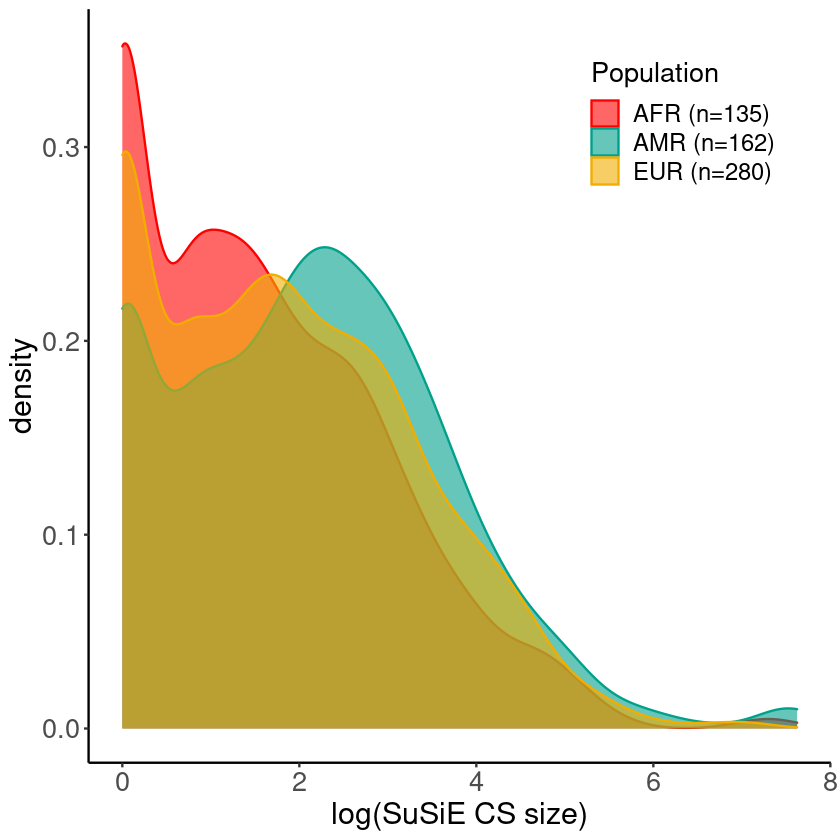

In [34]:
p <- ggplot(df, aes(x = log(cs_size), fill = Population, color = Population)) +
    geom_density(alpha = .6) +
    theme_classic() + 
    labs(x = "log(SuSiE CS size)") +
    scale_fill_manual(values = wes_palette("Darjeeling1")) +
    scale_color_manual(values = wes_palette("Darjeeling1")) +
#     scale_fill_brewer(palette = "Set1") +
#     scale_color_brewer(palette = "Set1") +
    theme(axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = c(0.8, 0.85)) 
#     geom_vline(xintercept = mean(log(eur$cs_size)), 
#                color = "yellow", linetype = "dashed", size = 1) +
#     geom_vline(xintercept = mean(log(amr$cs_size)), 
#                color = "green", linetype = "dashed", size = 1) +
#     geom_vline(xintercept = mean(log(afr$cs_size)), 
#                color = "red", linetype = "dashed", size = 1) 
p

In [36]:
ggsave("../../figures/susie_compare.pdf", p, width = 6, height = 6)

**Add ALL to the comparison**

In [10]:
shared_gene2 <- Reduce(intersect, 
                       list(cs_id_size_eur$phenotype_id, 
                            cs_id_size_amr$phenotype_id, 
                            cs_id_size_afr$phenotype_id,
                            cs_id_size_all$phenotype_id))
length(shared_gene2)

[1] 888

In [37]:
all <- cs_id_size_all %>% filter(phenotype_id %in% shared_gene)
all$Population <- "ALL (n=629)"
df2 <- df %>% select(cs_id, cs_size, finemapped_region, phenotype_id, Population) %>% rbind(all)

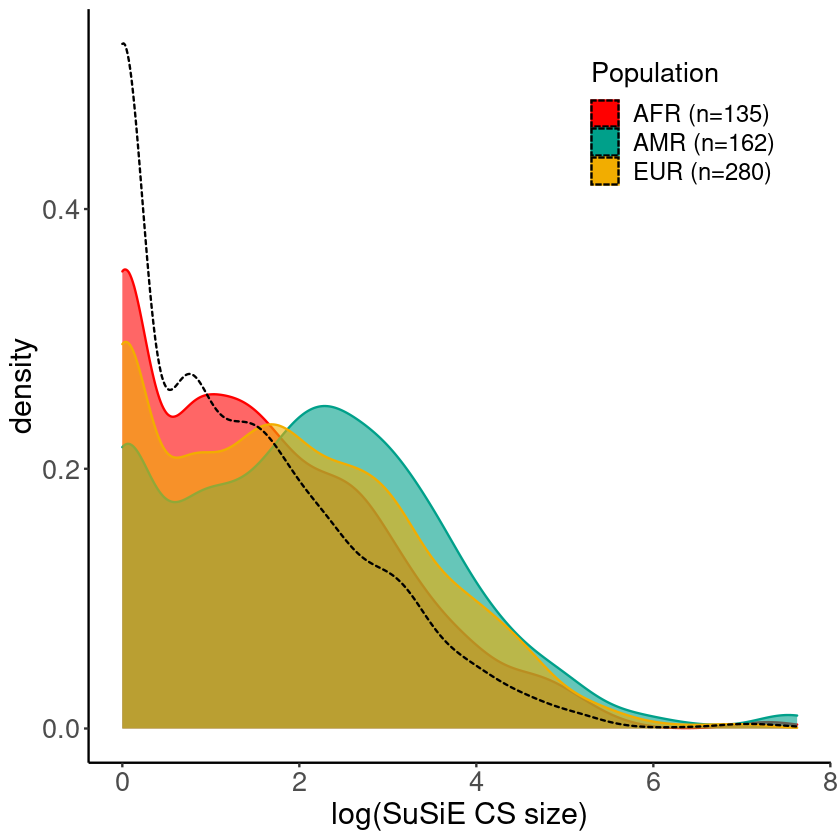

In [38]:
ggplot(data = df, aes(x = log(cs_size), fill = Population, color = Population)) +
    geom_density(alpha = .6) +
    theme_classic() + 
    labs(x = "log(SuSiE CS size)") +
    scale_fill_manual(values = wes_palette("Darjeeling1")) +
    scale_color_manual(values = wes_palette("Darjeeling1")) +
    theme(axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = c(0.8, 0.85)) +
    geom_density(data = all, inherit.aes = FALSE, aes(x = log(cs_size)), linetype = "dashed")

In [39]:
ggsave("../../figures/susie_all.pdf", width = 6, height = 6)

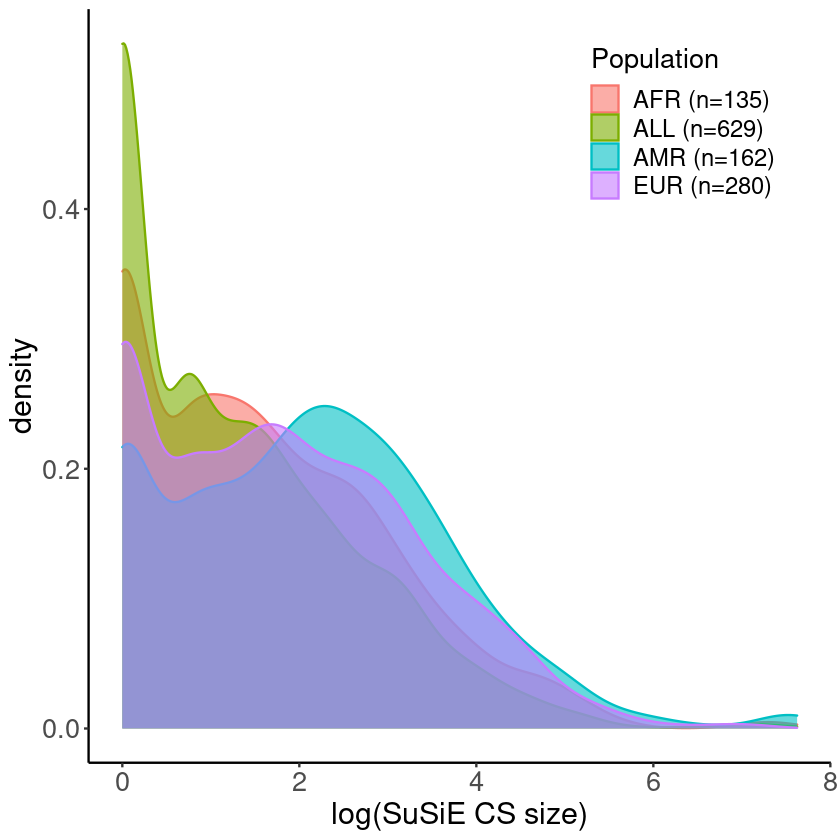

In [40]:
ggplot(df2, aes(x = log(cs_size), fill = Population, color = Population)) +
    geom_density(alpha = .6) +
    theme_classic() + 
    labs(x = "log(SuSiE CS size)") +
#     scale_fill_manual(values = wes_palette("Darjeeling1")) +
#     scale_color_manual(values = wes_palette("Darjeeling1")) +
#     scale_fill_brewer(palette = "Set1") +
#     scale_color_brewer(palette = "Set1") +
    theme(axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = c(0.8, 0.85)) 
#     geom_vline(xintercept = mean(log(eur$cs_size)), 
#                color = "yellow", linetype = "dashed", size = 1) +
#     geom_vline(xintercept = mean(log(amr$cs_size)), 
#                color = "green", linetype = "dashed", size = 1) +
#     geom_vline(xintercept = mean(log(afr$cs_size)), 
#                color = "red", linetype = "dashed", size = 1) 

## Filter for high PIP (0.8)

In [10]:
eur_shared <- sorted_df_eur %>% filter(phenotype_id %in% shared_gene, pip > .8)
dim(eur_shared)
amr_shared <- sorted_df_amr %>% filter(phenotype_id %in% shared_gene, pip > .8)
dim(amr_shared)
afr_shared <- sorted_df_afr %>% filter(phenotype_id %in% shared_gene, pip > .8)
dim(afr_shared)

# eur_shared_3 <- sorted_df_eur %>% filter(phenotype_id %in% shared_gene, pip > .3)
# dim(eur_shared_3)
# amr_shared_3 <- sorted_df_amr %>% filter(phenotype_id %in% shared_gene, pip > .3)
# dim(amr_shared_3)
# afr_shared_3 <- sorted_df_afr %>% filter(phenotype_id %in% shared_gene, pip > .3)
# dim(afr_shared_3)

[1] 377  17

[1] 260  17

[1] 397  17

**106 genes with high PIP variants are shared**

In [11]:
shared_gene_pip <- Reduce(intersect, list(eur_shared$phenotype_id, amr_shared$phenotype_id, afr_shared$phenotype_id))
length(unique(shared_gene_pip))

[1] 106

In [12]:
eur_test <- sorted_df_eur %>% filter(pip > .8)
amr_test <- sorted_df_amr %>% filter(pip > .8)
afr_test <- sorted_df_afr %>% filter(pip > .8)
length(Reduce(intersect, list(eur_test$phenotype_id, amr_test$phenotype_id, afr_test$phenotype_id)))

[1] 106

In [16]:
eur_pip <- eur_shared %>% filter(phenotype_id %in% shared_gene_pip)
dim(eur_pip)
length(unique(eur_pip$phenotype_id))
length(unique(eur_pip$variant_id))
amr_pip <- amr_shared %>% filter(phenotype_id %in% shared_gene_pip)
dim(amr_pip)
length(unique(amr_pip$phenotype_id))
length(unique(amr_pip$variant_id))
afr_pip <- afr_shared %>% filter(phenotype_id %in% shared_gene_pip)
dim(afr_pip)
length(unique(afr_pip$phenotype_id))
length(unique(afr_pip$variant_id))

[1] 135  17

[1] 106

[1] 120

[1] 116  17

[1] 106

[1] 104

[1] 125  17

[1] 106

[1] 114

In [50]:
sum(unique(eur_pip$variant_id) %in% unique(amr_pip$variant_id))
sum(unique(eur_pip$variant_id) %in% unique(afr_pip$variant_id))
sum(unique(amr_pip$variant_id) %in% unique(afr_pip$variant_id))
length(Reduce(intersect, list(unique(eur_pip$variant_id), 
                              unique(amr_pip$variant_id), 
                              unique(afr_pip$variant_id))))

[1] 50

[1] 29

[1] 40

[1] 24

png 
  2

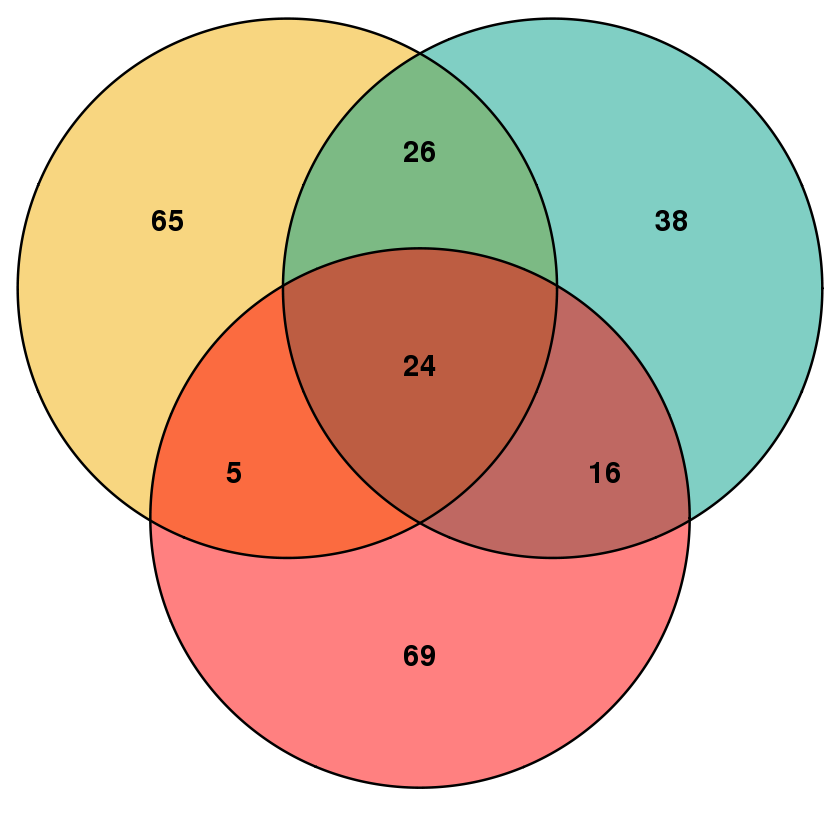

In [52]:
# area1, area2, area3, n12, n23, n13, n123
venn.plot <- draw.triple.venn(120, 104, 114, 50, 40, 29, 24, 
                              fill = c("#F2AD00", "#00A08A", "#FF0000"),
                              alpha = c(.5,.5,.5),
                              cex = 1.5,
                              fontface = 2,
                              fontfamily = rep("sans",7),
                              category = c("", "", ""), 
                              scaled = TRUE)
pdf("../../figures/pip8.pdf", width = 4, height = 4)
grid.draw(venn.plot)
dev.off()

**gene-variant pair**

In [17]:
eur_pip <- eur_pip %>% unite(pair, phenotype_id, variant_id, sep = ":", remove = FALSE)
amr_pip <- amr_pip %>% unite(pair, phenotype_id, variant_id, sep = ":", remove = FALSE)
afr_pip <- afr_pip %>% unite(pair, phenotype_id, variant_id, sep = ":", remove = FALSE)

In [18]:
length(unique(eur_pip$pair))

[1] 135

In [19]:
sum(unique(eur_pip$pair) %in% unique(amr_pip$pair))
sum(unique(eur_pip$pair) %in% unique(afr_pip$pair))
sum(unique(amr_pip$pair) %in% unique(afr_pip$pair))
length(Reduce(intersect, list(unique(eur_pip$pair), 
                              unique(amr_pip$pair), 
                              unique(afr_pip$pair))))

[1] 56

[1] 30

[1] 45

[1] 25

png 
  2

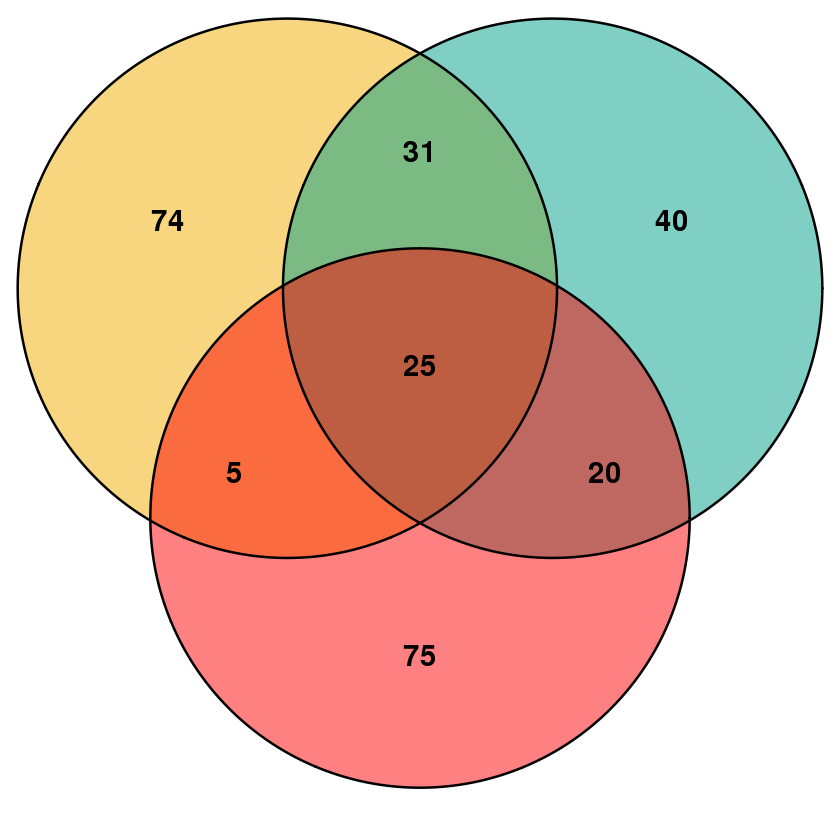

In [30]:
# area1, area2, area3, n12, n23, n13, n123
venn.plot <- draw.triple.venn(135, 116, 125, 56, 45, 30, 25, 
                              fill = c("#F2AD00", "#00A08A", "#FF0000"),
                              alpha = c(.5,.5,.5),
                              cex = 1.5,
                              fontface = 2,
                              fontfamily = rep("sans",7),
                              category = c("", "", ""), 
                              scaled = TRUE)
pdf("../../figures/pip8.pdf", width = 4, height = 4)
grid.draw(venn.plot)
dev.off()

## Investigate un-replicated high PIP variants for the 106 shared genes

In [22]:
eur_amr_pip_shared <- eur_pip %>% inner_join(amr_pip, by = "pair")

In [23]:
dim(eur_amr_pip_shared)

[1] 56 35

In [24]:
eur_amr_pip_shared <- eur_amr_pip_shared %>% filter(!pair %in% afr_pip$pair)

In [25]:
dim(eur_amr_pip_shared)

[1] 31 35

In [26]:
afr_pip_only <- afr_pip %>% filter(!pair %in% c(amr_pip$pair, eur_pip$pair))

In [27]:
dim(afr_pip_only)

[1] 75 18

In [38]:
afr_gene <- unique(afr_pip_only$phenotype_id)
eur_amr_gene <- unique(eur_amr_pip_shared$phenotype_id.x)

In [40]:
afr_gene[afr_gene %in% eur_amr_gene]

[1] "ENSG00000134202" "ENSG00000110074" "ENSG00000110455" "ENSG00000243323"
 [5] "ENSG00000257176" "ENSG00000197454" "ENSG00000198128" "ENSG00000196071"
 [9] "ENSG00000197728" "ENSG00000238286" "ENSG00000100744" "ENSG00000183793"
[13] "ENSG00000131484" "ENSG00000266918" "ENSG00000241015" "ENSG00000121413"
[17] "ENSG00000176293" "ENSG00000267216" "ENSG00000224635" "ENSG00000224790"
[21] "ENSG00000099977" "ENSG00000273295" "ENSG00000242086" "ENSG00000164306"
[25] "ENSG00000204961" "ENSG00000250120" "ENSG00000255389" "ENSG00000206503"
[29] "ENSG00000123965" "ENSG00000106853"

In [41]:
length(afr_gene)

[1] 62

In [57]:
for (gene in afr_gene[afr_gene %in% eur_amr_gene]) {
    afr_variant <- (afr_pip_only %>% filter(phenotype_id == gene) %>% select(variant_id))$variant_id
    if(nrow(sorted_df_eur %>% filter(variant_id == afr_variant)) != 0 &
       nrow(sorted_df_amr %>% filter(variant_id == afr_variant)) != 0) {
        print(gene)
    }
}

[1] "ENSG00000196071"
[1] "ENSG00000238286"
[1] "ENSG00000242086"


**ENSG00000196071**

In [58]:
# chr1_248100768_C_G exisit in all 3 populations
# CS of ENSG00000196071 of AFR and AMR, not EUR
# high PIP in AFR, low in AMR
# ideally would be in CS of the gene in all 3 populations
afr_pip_only %>% filter(phenotype_id == "ENSG00000196071")

pair,phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000196071:chr1_248100768_C_G,ENSG00000196071,chr1_248100768_C_G,1,248100768,C,G,ENSG00000196071_L1,L1,chr1:247258485-249258485,0.9352806,7.130576,0.4159899,0.6764839,2,1.47127,0.4331967,8.611078


In [59]:
eur_amr_pip_shared %>% filter(phenotype_id.x == "ENSG00000196071")

pair,phenotype_id.x,variant_id.x,chr.x,pos.x,ref.x,alt.x,cs_id.x,cs_index.x,finemapped_region.x,⋯,cs_index.y,finemapped_region.y,pip.y,z.y,cs_min_r2.y,cs_avg_r2.y,cs_size.y,posterior_mean.y,posterior_sd.y,cs_log10bf.y
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000196071:chr1_248100548_G_C,ENSG00000196071,chr1_248100548_G_C,1,248100548,G,C,ENSG00000196071_L1,L1,chr1:247258485-249258485,⋯,L1,chr1:247258485-249258485,0.9990819,8.388399,1,1,1,0.6697176,0.08193293,10.80299


In [60]:
sorted_df_eur %>% filter(variant_id == "chr1_248100768_C_G")
sorted_df_amr %>% filter(variant_id == "chr1_248100768_C_G")

phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000237492,chr1_248100768_C_G,1,248100768,C,G,ENSG00000237492_L2,L2,chr1:247138042-249138042,0.02572981,5.448628,0.8565942,0.9648561,41,0.02062565,0.1327139,3.710991


phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000187080,chr1_248100768_C_G,1,248100768,C,G,ENSG00000187080_L2,L2,chr1:247128534-249128534,0.03433296,5.438479,0.7096026,0.9382633,40,0.04912776,0.2656336,2.820346
ENSG00000196071,chr1_248100768_C_G,1,248100768,C,G,ENSG00000196071_L2,L2,chr1:247258485-249258485,0.03930157,5.550690,0.8431418,0.9707786,10,0.06163496,0.3146123,3.304023
ENSG00000197454,chr1_248100768_C_G,1,248100768,C,G,ENSG00000197454_L2,L2,chr1:247176961-249176961,0.04888841,5.663528,0.8431418,0.9707786,10,0.07341222,0.3338300,3.243594
ENSG00000198128,chr1_248100768_C_G,1,248100768,C,G,ENSG00000198128_L2,L2,chr1:247210137-249210137,0.56555556,6.187201,0.8431418,0.9707786,10,0.93474712,0.8452450,3.472389
ENSG00000203663,chr1_248100768_C_G,1,248100768,C,G,ENSG00000203663_L3,L3,chr1:247193371-249193371,0.08004237,5.130445,0.7096026,0.9360574,38,0.05713949,0.1979180,3.605092
ENSG00000224830,chr1_248100768_C_G,1,248100768,C,G,ENSG00000224830_L2,L2,chr1:247102274-249102274,0.13116823,6.284603,0.8431418,0.9707786,10,0.23966615,0.6261597,4.516701
ENSG00000232215,chr1_248100768_C_G,1,248100768,C,G,ENSG00000232215_L2,L2,chr1:247166430-249166430,0.54675339,5.433020,0.8431418,0.9707786,10,0.94587493,0.8951023,1.925895
ENSG00000279263,chr1_248100768_C_G,1,248100768,C,G,ENSG00000279263_L1,L1,chr1:247112159-249112159,0.07402963,6.198502,0.8431418,0.9707786,10,0.12633764,0.4565328,4.370047


In [66]:
sorted_df_afr %>% filter(phenotype_id =="ENSG00000196071")
sorted_df_eur %>% filter(phenotype_id =="ENSG00000196071")
sorted_df_amr %>% filter(phenotype_id =="ENSG00000196071")

phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000196071,chr1_248100718_C_T,1,248100718,C,T,ENSG00000196071_L1,L1,chr1:247258485-249258485,0.06835856,6.489734,0.4159899,0.6764839,2,0.0763926,0.2902602,8.611078
ENSG00000196071,chr1_248100768_C_G,1,248100768,C,G,ENSG00000196071_L1,L1,chr1:247258485-249258485,0.93528058,7.130576,0.4159899,0.6764839,2,1.4712701,0.4331967,8.611078


phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000196071,chr1_247790679_G_C,1,247790679,G,C,ENSG00000196071_L4,L4,chr1:247258485-249258485,0.004821646,1.328978,0.4127106,0.7691700,8,0.0017256745,0.02804464,1.470495
ENSG00000196071,chr1_247795893_C_T,1,247795893,C,T,ENSG00000196071_L4,L4,chr1:247258485-249258485,0.163738600,2.111085,0.4127106,0.7691700,8,0.0774779181,0.18001922,1.470495
ENSG00000196071,chr1_247796319_C_T,1,247796319,C,T,ENSG00000196071_L4,L4,chr1:247258485-249258485,0.398371127,2.326484,0.4127106,0.7691700,8,0.1973086116,0.25069757,1.470495
ENSG00000196071,chr1_247799643_G_A,1,247799643,G,A,ENSG00000196071_L4,L4,chr1:247258485-249258485,0.164712224,2.325360,0.4127106,0.7691700,8,0.0741144781,0.17159733,1.470495
ENSG00000196071,chr1_247800248_G_A,1,247800248,G,A,ENSG00000196071_L4,L4,chr1:247258485-249258485,0.163738600,2.111085,0.4127106,0.7691700,8,0.0774779181,0.18001922,1.470495
ENSG00000196071,chr1_247803437_C_A,1,247803437,C,A,ENSG00000196071_L4,L4,chr1:247258485-249258485,0.055226149,2.036015,0.4127106,0.7691700,8,0.0225494341,0.09631563,1.470495
ENSG00000196071,chr1_247805797_C_T,1,247805797,C,T,ENSG00000196071_L4,L4,chr1:247258485-249258485,0.003260805,1.763479,0.4127106,0.7691700,8,0.0009726739,0.02065917,1.470495
ENSG00000196071,chr1_247809004_A_G,1,247809004,A,G,ENSG00000196071_L4,L4,chr1:247258485-249258485,0.003260805,1.763479,0.4127106,0.7691700,8,0.0009726739,0.02065917,1.470495
ENSG00000196071,chr1_248100548_G_C,1,248100548,G,C,ENSG00000196071_L1,L1,chr1:247258485-249258485,1.000000000,10.894846,1.0000000,1.0000000,1,0.6251859380,0.04426768,38.535210


phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000196071,chr1_248100548_G_C,1,248100548,G,C,ENSG00000196071_L1,L1,chr1:247258485-249258485,0.99908186,8.388399,1.0000000,1.0000000,1,0.66971757,0.08193293,10.802992
ENSG00000196071,chr1_248100768_C_G,1,248100768,C,G,ENSG00000196071_L2,L2,chr1:247258485-249258485,0.03930157,5.550690,0.8431418,0.9707786,10,0.06163496,0.31461231,3.304023
ENSG00000196071,chr1_248101302_G_A,1,248101302,G,A,ENSG00000196071_L2,L2,chr1:247258485-249258485,0.10519853,5.670349,0.8431418,0.9707786,10,0.18914385,0.56438606,3.304023
ENSG00000196071,chr1_248103672_T_C,1,248103672,T,C,ENSG00000196071_L2,L2,chr1:247258485-249258485,0.10519853,5.670349,0.8431418,0.9707786,10,0.18914385,0.56438606,3.304023
ENSG00000196071,chr1_248104736_C_T,1,248104736,C,T,ENSG00000196071_L2,L2,chr1:247258485-249258485,0.10519853,5.670349,0.8431418,0.9707786,10,0.18914385,0.56438606,3.304023
ENSG00000196071,chr1_248104860_A_G,1,248104860,A,G,ENSG00000196071_L2,L2,chr1:247258485-249258485,0.10519853,5.670349,0.8431418,0.9707786,10,0.18914385,0.56438606,3.304023
ENSG00000196071,chr1_248106240_C_T,1,248106240,C,T,ENSG00000196071_L2,L2,chr1:247258485-249258485,0.10519853,5.670349,0.8431418,0.9707786,10,0.18914385,0.56438606,3.304023
ENSG00000196071,chr1_248106524_A_G,1,248106524,A,G,ENSG00000196071_L2,L2,chr1:247258485-249258485,0.10519853,5.670349,0.8431418,0.9707786,10,0.18914385,0.56438606,3.304023
ENSG00000196071,chr1_248106578_G_A,1,248106578,G,A,ENSG00000196071_L2,L2,chr1:247258485-249258485,0.10519853,5.670349,0.8431418,0.9707786,10,0.18914385,0.56438606,3.304023


**ENSG00000238286**

In [61]:
afr_pip_only %>% filter(phenotype_id == "ENSG00000238286")
eur_amr_pip_shared %>% filter(phenotype_id.x == "ENSG00000238286")

pair,phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000238286:chr13_21257791_C_T,ENSG00000238286,chr13_21257791_C_T,13,21257791,C,T,ENSG00000238286_L1,L1,chr13:20181406-22181406,0.9904213,15.64016,1,1,1,1.314293,0.1469882,72.46606


pair,phenotype_id.x,variant_id.x,chr.x,pos.x,ref.x,alt.x,cs_id.x,cs_index.x,finemapped_region.x,⋯,cs_index.y,finemapped_region.y,pip.y,z.y,cs_min_r2.y,cs_avg_r2.y,cs_size.y,posterior_mean.y,posterior_sd.y,cs_log10bf.y
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000238286:chr13_21205124_T_TG,ENSG00000238286,chr13_21205124_T_TG,13,21205124,T,TG,ENSG00000238286_L1,L1,chr13:20181406-22181406,⋯,L1,chr13:20181406-22181406,0.9757598,10.15333,1,1,1,0.9383647,0.1714301,21.47645


In [62]:
sorted_df_eur %>% filter(variant_id == "chr13_21257791_C_T")
sorted_df_amr %>% filter(variant_id == "chr13_21257791_C_T")

phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000222726,chr13_21257791_C_T,13,21257791,C,T,ENSG00000222726_L1,L1,chr13:20186299-22186299,0.01050437,10.3779,0.6468444,0.8624194,59,0.007976885,0.08544814,20.64593


phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000222726,chr13_21257791_C_T,13,21257791,C,T,ENSG00000222726_L1,L1,chr13:20186299-22186299,0.08451343,7.639803,0.8800629,0.9916836,36,0.09669708,0.3211349,9.805648


**ENSG00000242086**

In [63]:
afr_pip_only %>% filter(phenotype_id == "ENSG00000242086")
eur_amr_pip_shared %>% filter(phenotype_id.x == "ENSG00000242086")

pair,phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000242086:chr3_195745525_TCA_T,ENSG00000242086,chr3_195745525_TCA_T,3,195745525,TCA,T,ENSG00000242086_L1,L1,chr3:194384932-196384932,0.9997075,-6.274343,1,1,1,-0.6010823,0.090651,4.982382


pair,phenotype_id.x,variant_id.x,chr.x,pos.x,ref.x,alt.x,cs_id.x,cs_index.x,finemapped_region.x,⋯,cs_index.y,finemapped_region.y,pip.y,z.y,cs_min_r2.y,cs_avg_r2.y,cs_size.y,posterior_mean.y,posterior_sd.y,cs_log10bf.y
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000242086:chr3_195725308_A_ATTTC,ENSG00000242086,chr3_195725308_A_ATTTC,3,195725308,A,ATTTC,ENSG00000242086_L1,L1,chr3:194384932-196384932,⋯,L1,chr3:194384932-196384932,0.99996,-8.647613,1,1,1,-0.6373647,0.05856664,21.02423


In [64]:
sorted_df_eur %>% filter(variant_id == "chr3_195745525_TCA_T")
sorted_df_amr %>% filter(variant_id == "chr3_195745525_TCA_T")

phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000207650,chr3_195745525_TCA_T,3,195745525,TCA,T,ENSG00000207650_L1,L1,chr3:194426271-196426271,0.9923052,-5.425915,1,1,1,-0.3751585,0.06423228,5.576012


phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ENSG00000260261,chr3_195745525_TCA_T,3,195745525,TCA,T,ENSG00000260261_L1,L1,chr3:194681355-196681355,0.1105759,-5.008664,0.5728833,0.7976933,6,-0.04482523,0.1307992,1.925262


**To prepare input files for locuszoom**
- `zcat all_assoc.txt.gz | awk '$1 == "ENSG00000196071" {print $0}' > ENSG00000196071.all_assoc.txt`
- some markers are rsID, some are hg38 chr:pos, need to change all to hg19 chr:pos. Generated variant coordinate file for ancestries

**EUR and AFR non-overlapping high PIP variants for shared genes: MAF? Are they not present in the other population?**

In [13]:
# EUR and AFR: 29 shared variants
eur_afr_share <- data.frame(unique(eur_pip$variant_id)[unique(eur_pip$variant_id) %in% unique(afr_pip$variant_id)])
dim(eur_afr_share)
colnames(eur_afr_share) <- "variant"
head(eur_afr_share)

[1] 29  1

,variant
,<fct>
1,chr10_102791911_C_A
2,chr10_120920588_T_C
3,chr10_123688152_A_T
4,chr1_159825916_C_T
5,chr11_780827_C_T
6,chr12_10096086_G_C


In [14]:
# EUR, not AFR, 91
eur_unique <- data.frame(unique(eur_pip$variant_id)[!unique(eur_pip$variant_id) %in% unique(afr_pip$variant_id)])
colnames(eur_unique) <- "variant"
dim(eur_unique)

[1] 91  1

In [15]:
# AFR, not EUR, 85
afr_unique <- data.frame(unique(afr_pip$variant_id)[!unique(afr_pip$variant_id) %in% unique(eur_pip$variant_id)])
colnames(afr_unique) <- "variant"
dim(afr_unique)

[1] 85  1

In [16]:
df <- rbind(eur_afr_share, eur_unique, afr_unique)
df$Group <- c(rep("EUR AFR shared", nrow(eur_afr_share)), 
              rep("EUR unique", nrow(eur_unique)), 
              rep("AFR unique", nrow(afr_unique)))
head(df)

,variant,Group
,<fct>,<chr>
1,chr10_102791911_C_A,EUR AFR shared
2,chr10_120920588_T_C,EUR AFR shared
3,chr10_123688152_A_T,EUR AFR shared
4,chr1_159825916_C_T,EUR AFR shared
5,chr11_780827_C_T,EUR AFR shared
6,chr12_10096086_G_C,EUR AFR shared


In [17]:
# eur_maf <- fread("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/eur/maf.gz", data.table = F, header = F)
eur_maf <- fread("~/project-gandalm/isoform_twas/genotype/temp/eur.maf.gz", data.table = F, header = F)
dim(eur_maf)
head(eur_maf)

[1] 9309498       5

,V1,V2,V3,V4,V5
,<int>,<int>,<chr>,<chr>,<dbl>
1,1,662622,G,A,0.13356200
2,1,666249,C,T,0.00171233
3,1,693731,A,G,0.13356200
4,1,693823,G,C,0.13698600
5,1,704637,G,A,0.03767120
6,1,708075,A,G,0.00342466


In [18]:
# afr_maf <- fread("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/afr/maf.gz", data.table = F, header = F)
afr_maf <- fread("~/project-gandalm/isoform_twas/genotype/temp/afr.maf.gz", data.table = F, header = F)
dim(afr_maf)

[1] 9293514       5

In [19]:
eur_maf <- eur_maf %>% unite("id", V1,V2,V3,V4,sep="_")

In [20]:
eur_maf$id <- gsub("^","chr",eur_maf$id)

In [21]:
afr_maf <- afr_maf %>% unite("id", V1,V2,V3,V4,sep="_")
afr_maf$id<- gsub("^","chr",afr_maf$id)

In [22]:
df <- df %>% left_join(eur_maf, by=c("variant"="id"))

In [23]:
df <- df %>% left_join(afr_maf, by=c("variant"="id"))

In [24]:
colnames(df)[3:4] <- c("eur_maf", "afr_maf")
head(df)

,variant,Group,eur_maf,afr_maf
,<chr>,<chr>,<dbl>,<dbl>
1,chr10_102791911_C_A,EUR AFR shared,0.1386990,0.0551724
2,chr10_120920588_T_C,EUR AFR shared,0.4914380,0.4241380
3,chr10_123688152_A_T,EUR AFR shared,0.3133560,0.1793100
4,chr1_159825916_C_T,EUR AFR shared,0.3681510,0.0758621
5,chr11_780827_C_T,EUR AFR shared,0.4366440,0.1655170
6,chr12_10096086_G_C,EUR AFR shared,0.0445205,0.1206900


In [25]:
dim(df)
sum(complete.cases(df))

[1] 205   4

[1] 161

In [62]:
# present in both populations? Absent in one due to failing variants QC?
# df$state <- ifelse(complete.cases(df), "present", "absent")

In [26]:
# table(df$state)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 44 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 44 rows containing missing values (geom_point).”


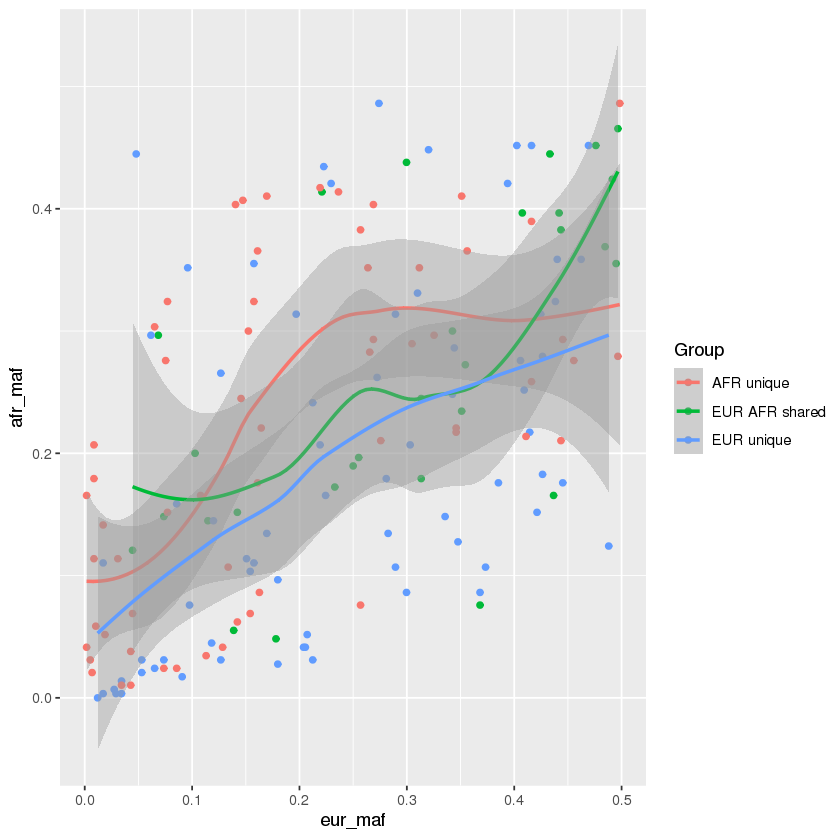

In [27]:
p <- ggplot(df, aes(x = eur_maf, y = afr_maf, color = Group)) +
    geom_point() +
    geom_smooth()
p

## maxCPP annotation for sLDSC
Use susie PIP as CAVIAR CPP

In [7]:
head(sorted_df_all)

,phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,ENSG00000166024,chr10_100003785_T_C,10,100003785,T,C,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.068322868,-6.900330,0.8706241,0.9776713,24,-0.012146753,0.04585326,6.840422
2,ENSG00000166024,chr10_100008436_G_A,10,100008436,G,A,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.021124867,-6.704314,0.8706241,0.9776713,24,-0.003453998,0.02464589,6.840422
3,ENSG00000166024,chr10_100011970_G_A,10,100011970,G,A,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.021124867,-6.704314,0.8706241,0.9776713,24,-0.003453998,0.02464589,6.840422
4,ENSG00000166024,chr10_100013244_A_C,10,100013244,A,C,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.050424642,-6.848917,0.8706241,0.9776713,24,-0.008776639,0.03908357,6.840422
5,ENSG00000119943,chr10_100164441_T_C,10,100164441,T,C,ENSG00000119943_L1,L1,chr10:99174938-101174938,0.008835407,7.490109,0.6954467,0.9374778,42,0.002248738,0.02611878,9.666004
6,ENSG00000119943,chr10_100164442_A_G,10,100164442,A,G,ENSG00000119943_L1,L1,chr10:99174938-101174938,0.008835407,7.490109,0.6954467,0.9374778,42,0.002248738,0.02611878,9.666004


In [63]:
sorted_df_all1 <- sorted_df_all %>% 
    group_by(variant_id) %>% 
    mutate(maxCPP = max(pip)) %>% 
    select(chr, pos, variant_id, maxCPP)

In [64]:
head(sorted_df_all1)

chr,pos,variant_id,maxCPP
<int>,<int>,<chr>,<dbl>
10,100003785,chr10_100003785_T_C,0.068322868
10,100008436,chr10_100008436_G_A,0.021124867
10,100011970,chr10_100011970_G_A,0.021124867
10,100013244,chr10_100013244_A_C,0.050424642
10,100164441,chr10_100164441_T_C,0.008835407
10,100164442,chr10_100164442_A_G,0.008835407


In [67]:
length(unique(sorted_df_all1$variant_id))

[1] 122050

In [70]:
sorted_df_all1 <- sorted_df_all1[!duplicated(sorted_df_all1$variant_id),]

In [71]:
dim(sorted_df_all1)

[1] 122050      4

LDSC `make_annot.py` cannot generate continuous annnotations. Generate manually. Follow format `/u/project/gandalm/shared/LDSCORE/LDSC_QTL/Annot/Brain_Cortex_Analysis_MaxCPP`. Note the order of annotations should be the same as variants in EUR bim file.
The script merges by coordinates in set file and bim file, not ID.

In [73]:
bim <- fread("/u/project/gandalm/shared/apps/ldsc/LDSCORE/1000G_EUR_Phase3_plink/1000G.EUR.QC.21.bim", data.table = F)

In [74]:
head(bim)

,V1,V2,V3,V4,V5,V6
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>
1,21,rs146134162,-0.9082633,9412099,T,C
2,21,rs578050168,-0.9080896,9412377,A,G
3,21,rs527616997,-0.9072975,9413645,G,T
4,21,rs544748596,-0.9065784,9414796,A,G
5,21,rs528236937,-0.9065003,9414921,A,G
6,21,rs575656951,-0.9063191,9415211,G,A


In [75]:
bim <- bim %>% left_join(sorted_df_all1, by=c("V1"="chr", "V4"="pos"))

In [76]:
head(bim)

,V1,V2,V3,V4,V5,V6,variant_id,maxCPP
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>
1,21,rs146134162,-0.9082633,9412099,T,C,NA,NA
2,21,rs578050168,-0.9080896,9412377,A,G,NA,NA
3,21,rs527616997,-0.9072975,9413645,G,T,NA,NA
4,21,rs544748596,-0.9065784,9414796,A,G,NA,NA
5,21,rs528236937,-0.9065003,9414921,A,G,NA,NA
6,21,rs575656951,-0.9063191,9415211,G,A,NA,NA


In [77]:
sum(complete.cases(bim))

[1] 820

In [79]:
bim$maxCPP[is.na(bim$maxCPP)] <- 0

In [80]:
head(bim)

,V1,V2,V3,V4,V5,V6,variant_id,maxCPP
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>
1,21,rs146134162,-0.9082633,9412099,T,C,NA,0
2,21,rs578050168,-0.9080896,9412377,A,G,NA,0
3,21,rs527616997,-0.9072975,9413645,G,T,NA,0
4,21,rs544748596,-0.9065784,9414796,A,G,NA,0
5,21,rs528236937,-0.9065003,9414921,A,G,NA,0
6,21,rs575656951,-0.9063191,9415211,G,A,NA,0


In [81]:
head(bim[complete.cases(bim),])

,V1,V2,V3,V4,V5,V6,variant_id,maxCPP
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>
52807,21,rs11087960,23.23943,26835998,A,G,chr21_26835998_G_A,0.184710433
52864,21,rs12483727,23.24094,26856851,T,A,chr21_26856851_A_T,0.115297953
52868,21,rs1015045,23.24124,26858136,A,T,chr21_26858136_T_A,0.652243454
52996,21,rs1783079,23.25661,26917117,G,A,chr21_26917117_A_G,0.436417297
52997,21,rs1782970,23.25663,26917171,T,C,chr21_26917171_C_T,0.011779151
53000,21,rs1783080,23.25688,26918229,G,T,chr21_26918229_T_G,0.007427206


In [61]:
bim <- bim %>% select(V1, V4, V2, V3.x, maxCPP)
head(bim)

,V1,V4,V2,V3.x,maxCPP
,<int>,<int>,<chr>,<dbl>,<dbl>
1,21,9412099,rs146134162,-0.9082633,0
2,21,9412377,rs578050168,-0.9080896,0
3,21,9413645,rs527616997,-0.9072975,0
4,21,9414796,rs544748596,-0.9065784,0
5,21,9414921,rs528236937,-0.9065003,0
6,21,9415211,rs575656951,-0.9063191,0


In [62]:
colnames(bim) <- c("CHR", "BP", "SNP", "CM", "maxCPP")

In [82]:
head(bim[bim$maxCPP != 0,])

,V1,V2,V3,V4,V5,V6,variant_id,maxCPP
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>
52807,21,rs11087960,23.23943,26835998,A,G,chr21_26835998_G_A,0.184710433
52864,21,rs12483727,23.24094,26856851,T,A,chr21_26856851_A_T,0.115297953
52868,21,rs1015045,23.24124,26858136,A,T,chr21_26858136_T_A,0.652243454
52996,21,rs1783079,23.25661,26917117,G,A,chr21_26917117_A_G,0.436417297
52997,21,rs1782970,23.25663,26917171,T,C,chr21_26917171_C_T,0.011779151
53000,21,rs1783080,23.25688,26918229,G,T,chr21_26918229_T_G,0.007427206
